## **Data Strutcure Accepted by Seaborn**

Seaborn supports several different dataset formats, and most functions accept data represented with objects from the pandas or numpy libraries as well as built-in Python types like lists and dictionaries.

### **Long-form vs. wide-form data**

There is a fundamental distinction between “long-form” and “wide-form” data tables, and seaborn will treat each differently

####**Long-form data**

A long-form data table has the following characteristics:

* Each variable is a column

* Each observation is a row

As a simple example, consider the “flights” dataset, which records the number of airline passengers who flew in each month from 1949 to 1960. This dataset has three variables (year, month, and number of passengers):

In [ ]:
!python -m pip install pip --upgrade --user -q 
!python -m pip install numpy pandas seaborn --user -q

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
flights = sns.load_dataset("flights")
flights.head()

With long-form data, columns in the table are given roles in the plot by explicitly assigning them to one of the variables. For example, making a monthly plot of the number of passengers per year looks like this:


In [ ]:
sns.relplot(data=flights, x="year", y="passengers", hue="month", kind="line")

The advantage of long-form data is that it lends itself well to this explicit specification of the plot. It can accomodate datasets of arbitrary complexity, so long as the variables and observations can be clearly defined. But this format takes some getting used to, because it is often not the model of the data that one has in their head.

####**Wide-form data**

For simple datasets, it is often more intuitive to think about data the way it might be viewed in a spreadsheet, where the columns and rows contain levels of different variables. 

For example, we can convert the flights dataset into a wide-form organization by “pivoting” it so that each column has each month’s time series over years:

In [ ]:
flights_wide = flights.pivot(index="year", columns="month", values="passengers")
flights_wide.head()

With long-form data, we can access variables in the dataset by their name. That is not the case with wide-form data. Nevertheless, because there is a clear association between the dimensions of the table and the variable in the dataset, seaborn is able to assign those variables roles in the plot.

In [ ]:
sns.relplot(data=flights_wide, kind="line")

This plot looks very similar to the one before. Seaborn has assigned the index of the dataframe to x, the values of the dataframe to y, and it has drawn a separate line for each month. There is a notable difference between the two plots, however. When the dataset went through the “pivot” operation that converted it from long-form to wide-form, the information about what the values mean was lost. As a result, there is no y axis label.

But a big advantage of long-form data is that, You can design your plots by thinking only about the variables contained within it. For example, to draw lines that represent the monthly time series for each year, simply reassign the variables:

In [ ]:
sns.relplot(data=flights, x="month", y="passengers", hue="year", kind="line")

To achieve the same remapping with the wide-form dataset, we would need to transpose the table:

In [ ]:
sns.relplot(data=flights_wide.transpose(), kind="line")

This example also illustrates another wrinkle, which is that seaborn currently considers the column variable in a wide-form dataset to be categorical regardless of its datatype, whereas, because the long-form variable is numeric, it is assigned a quantitative color palette and legend. This may change in the future.

The absence of explicit variable assignments also means that each plot type needs to define a fixed mapping between the dimensions of the wide-form data and the roles in the plot. Because ths natural mapping may vary across plot types, the results are less predictable when using wide-form data. For example, the categorical plots assign the column dimension of the table to x and then aggregate across the rows (ignoring the index):

In [ ]:
sns.catplot(data=flights_wide, kind="box")

In summary, we can think of long-form and wide-form datasets as looking something like this:

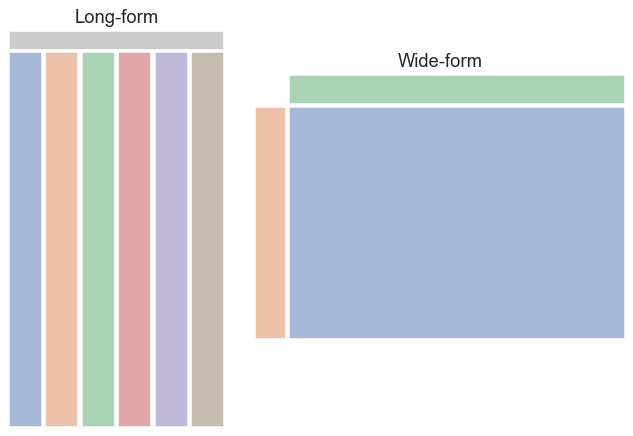

### **Messy data**

In a messy dataset, the variables are neither uniquely defined by the keys nor by the dimensions of the table. This often occurs with *repeated-measures data*, where it is natural to organize a table such that each row corresponds to the unit of data collection.

Consider this simple dataset from a psychology experiment in which twenty subjects performed a memory task where they studied anagrams while their attention was either divided or focused:

In [ ]:
anagrams = sns.load_dataset("anagrams")
anagrams

The attention variable is between-subjects, but there is also a within-subjects variable: the number of possible solutions to the anagrams, which varied from 1 to 3. The dependent measure is a score of memory performance. These two variables (number and score) are jointly encoded across several columns. As a result, the whole dataset is neither clearly long-form nor clearly wide-form.

How might we tell seaborn to plot the average score as a function of attention and number of solutions? We’d first need to coerce the data into one of our two structures. Let’s transform it to a tidy long-form table, such that each variable is a column and each row is an observation. We can use the method [pandas.DataFrame.melt()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.melt.html#pandas.DataFrame.melt) to accomplish this task:

In [ ]:
anagrams_long = anagrams.melt(id_vars=["subidr", "attnr"], var_name="solutions", value_name="score")
anagrams_long.head()

Now we can make the plot that we want:

In [ ]:
sns.catplot(data=anagrams_long, x="solutions", y="score", hue="attnr", kind="point")

### **Options for visualizing long-form data**

The examples in the rest of the documentation will typically use pandas.DataFrame objects and reference variables in them by assigning names of their columns to the variables in the plot. But it is also possible to store vectors in a Python dictionary or a class that implements that interface:

In [ ]:
flights_dict = flights.to_dict()
sns.relplot(data=flights_dict, x="year", y="passengers", hue="month", kind="line")

Many pandas operations, such as a the split-apply-combine operations of a group-by, will produce a dataframe where information has moved from the columns of the input dataframe to the index of the output. So long as the name is retained, you can still reference the data as normal:

In [ ]:
flights_avg = flights.groupby("year").mean()
sns.relplot(data=flights_avg, x="year", y="passengers", kind="line")

Additionally, it’s possible to pass vectors of data directly as arguments to `x`,` y`, and other plotting variables. If these vectors are pandas objects, the `name` attribute will be used to label the plot:

In [ ]:
year = flights_avg.index
passengers = flights_avg["passengers"]
sns.relplot(x=year, y=passengers, kind="line")

Numpy arrays and other objects that implement the Python sequence interface work too, but if they don’t have names, the plot will not be as informative without further tweaking:

In [ ]:
sns.relplot(x=year.to_numpy(), y=passengers.to_list(), kind="line")

### **Options for visualizing wide-form data**

The options for passing wide-form data are even more flexible.

The example we saw above used a rectangular pandas.DataFrame, which can be thought of as a collection of its columns. A dict or list of pandas objects will also work, but we’ll lose the axis labels:

In [ ]:
flights_wide_list = [col for _, col in flights_wide.items()]
sns.relplot(data=flights_wide_list, kind="line")

The vectors in a collection do not need to have the same length. If they have an index, it will be used to align them:

In [ ]:
two_series = [flights_wide.loc[:1955, "Jan"], flights_wide.loc[1952:, "Aug"]]
sns.relplot(data=two_series, kind="line")

Whereas an ordinal index will be used for numpy arrays or simple Python sequences:

In [ ]:
two_arrays = [s.to_numpy() for s in two_series]
sns.relplot(data=two_arrays, kind="line")

But a dictionary of such vectors will at least use the keys:

In [ ]:
two_arrays_dict = {s.name: s.to_numpy() for s in two_series}
sns.relplot(data=two_arrays_dict, kind="line")

Rectangular numpy arrays are treated just like a dataframe without index information, so they are viewed as a collection of column vectors. Note that this is different from how numpy indexing operations work, where a single indexer will access a row. But it is consistent with how pandas would turn the array into a dataframe or how matplotlib would plot it:

In [ ]:
flights_array = flights_wide.to_numpy()
sns.relplot(data=flights_array, kind="line")

#**Please refer [Official Tutorial](https://seaborn.pydata.org/tutorial.html) for more detailed explaination**